In [1]:
# change current directory to parent folder
import os
import sys

if not os.path.isdir("pypsa-earth"):
    os.chdir("../../..")
sys.path.append(os.getcwd()+"/pypsa-earth/scripts")

from scripts._helpers import three_2_two_digits_country

In [2]:
import os

scenario_name = ""  # scenario name, default value is "" for tutorial or default configuration
                    # value shall be non null if a scenario name is specified under the "run" tag in the config file

scenario_subpath = scenario_name + "/" if scenario_name else ""

# OSM raw data files
substations_OSMraw_path = (
    "/users/marih/test2/pypsa-earth/resources/" + scenario_subpath + "osm/raw/all_raw_substations.geojson"
)
lines_OSMraw_path = "/users/marih/test2/pypsa-earth/resources/" + scenario_subpath + "osm/raw/all_raw_lines.geojson"

# cleaned osm data files
substations_OSMclean_path = (
    "/users/marih/test2/pypsa-earth/resources/" + scenario_subpath + "osm/clean/all_clean_substations.geojson"
)
lines_OSMclean_path = "/users/marih/test2/pypsa-earth/resources/" + scenario_subpath + "osm/clean/all_clean_lines.geojson"

# shapes files
countries_shape_path = "/users/marih/test2/pypsa-earth/resources/" + scenario_subpath + "shapes/country_shapes.geojson"

# solve network output
solved_network_path = "/users/marih/test2/pypsa-earth/results/" + scenario_subpath + "networks/elec_s_4_ec_lcopt_Co2L-1H.nc"

In [3]:
# import packages

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature

from scipy.sparse import csgraph
from itertools import product
import re

from shapely.geometry import Point, LineString
import shapely, shapely.prepared
from shapely.wkt import loads
from shapely.validation import make_valid

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

c:\Users\marih\anaconda3\envs\pypsa-earth-test\lib\site-packages\pypsa\networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


In [4]:
# load substation geodataframe
df_substations_osm_clean = gpd.read_file(
    substations_OSMclean_path
)  # .to_crs(epsg=3857)
# df_substations_osm_clean = df_substations_osm_clean[
#     df_substations_osm_clean.country == "NG"
# ]
df_substations_osm_clean["geometry"] = df_substations_osm_clean["geometry"].apply(
    make_valid
)
# load lines geodataframe
df_lines_osm_clean = gpd.read_file(lines_OSMclean_path)  # .to_crs(epsg=3857)
# df_lines_osm_clean = df_lines_osm_clean[df_lines_osm_clean.country == "NG"]
df_lines_osm_clean["geometry"] = df_lines_osm_clean["geometry"].apply(make_valid)

c:\Users\marih\anaconda3\envs\pypsa-earth-test\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\marih\anaconda3\envs\pypsa-earth-test\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\marih\anaconda3\envs\pypsa-earth-test\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, pleas

(<matplotlib.collections.PatchCollection at 0x299ca91ca30>,
 <matplotlib.collections.LineCollection at 0x299ca91e6e0>)

c:\Users\marih\anaconda3\envs\pypsa-earth-test\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


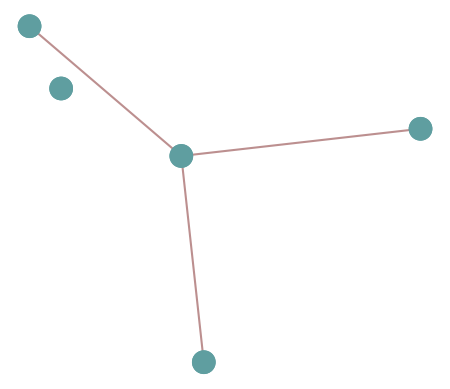

In [17]:
network = pypsa.Network(solved_network_path)

network.plot()


In [18]:
network.generators.p_nom_opt

Generator
BO0 0 CCGT       9.096900e+02
BO0 0 OCGT       7.497600e+02
BO0 0 biomass    5.064000e+01
BO0 0 onwind     7.267337e-07
BO0 0 solar      1.229078e-06
BO0 1 OCGT       4.925000e+01
BO0 1 biomass    4.940000e+00
BO0 1 oil        1.174000e+01
BO0 1 onwind     4.346252e-07
BO0 1 ror        2.111700e+02
BO0 1 solar      1.430254e-06
BO0 2 CCGT       4.543000e+02
BO0 2 onwind     6.481621e-07
BO0 2 ror        2.400000e+00
BO0 2 solar      8.600035e+02
BO0 3 OCGT       1.499100e+02
BO0 3 onwind     2.654000e+01
BO0 3 ror        1.323200e+02
BO0 3 solar      5.020000e+01
BO1 0 onwind     3.764921e-07
BO1 0 solar      3.824527e+02
BO0 0 load       1.000000e+09
BO0 1 load       1.000000e+09
BO0 2 load       1.000000e+09
BO0 3 load       1.000000e+09
BO1 0 load       1.000000e+09
Name: p_nom_opt, dtype: float64

In [19]:
network.statistics._parent

PyPSA Network
Components:
 - Bus: 10
 - Carrier: 12
 - Generator: 26
 - GlobalConstraint: 1
 - Line: 3
 - Link: 10
 - Load: 5
 - StorageUnit: 3
 - Store: 5
Snapshots: 8760

In [20]:
network.lines

,bus0,bus1,length,carrier,type,s_max_pu,s_nom,capital_cost,num_parallel,s_nom_extendable,s_nom_min,x,r,b,build_year,x_pu_eff,r_pu_eff,s_nom_opt,v_nom,g,s_nom_max,lifetime,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu
Line,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,BO0 0,BO0 3,380.475448,AC,Al/St 240/40 4-bundle 380.0,0.7,983.112038,14497.194060,0.578947,True,569.170127,161.667477,19.715546,0.000955,0,0.003340,0.000407,569.170129,220.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
2,BO0 1,BO0 3,322.726329,AC,Al/St 240/40 4-bundle 380.0,0.7,983.112038,12295.876104,0.578947,True,569.170127,137.129351,16.723092,0.000810,0,0.002833,0.000346,569.170127,220.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
3,BO0 2,BO0 3,343.851322,AC,Al/St 240/40 4-bundle 380.0,0.7,1966.224077,13101.230351,1.157895,True,1138.340255,73.052776,8.908875,0.001726,0,0.001509,0.000184,1138.340258,220.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0


In [21]:
network.buses

,v_nom,country,x,y,control,generator,carrier,type,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network
Bus,,,,,,,,,,,,,
BO0 0,220.0,BO,-63.379677,-17.627723,Slack,BO0 0 CCGT,AC,,,1.0,0.0,inf,
BO0 1,220.0,BO,-68.045187,-16.403467,PQ,,AC,,,1.0,0.0,inf,
BO0 2,220.0,BO,-65.965811,-20.412867,PQ,,AC,,,1.0,0.0,inf,
BO0 3,220.0,BO,-66.234285,-17.952030,PQ,,AC,,,1.0,0.0,inf,
BO1 0,220.0,BO,-67.668100,-17.146800,Slack,BO1 0 onwind,AC,,,1.0,0.0,inf,
BO0 0 battery,1.0,BO,-63.379677,-17.627723,Slack,,battery,,,1.0,0.0,inf,
BO0 1 battery,1.0,BO,-68.045187,-16.403467,Slack,,battery,,,1.0,0.0,inf,
BO0 2 battery,1.0,BO,-65.965811,-20.412867,Slack,,battery,,,1.0,0.0,inf,
BO0 3 battery,1.0,BO,-66.234285,-17.952030,Slack,,battery,,,1.0,0.0,inf,


In [22]:
network.loads

,bus,carrier,type,p_set,q_set,sign
Load,,,,,,
BO0 0,BO0 0,,,0.0,0.0,-1.0
BO0 1,BO0 1,,,0.0,0.0,-1.0
BO0 2,BO0 2,,,0.0,0.0,-1.0
BO0 3,BO0 3,,,0.0,0.0,-1.0
BO1 0,BO1 0,,,0.0,0.0,-1.0


In [23]:
network.loads_t

{'p_set': Load                      BO0 0       BO0 1       BO0 2       BO0 3      BO1 0
 snapshot                                                                      
 2013-01-01 00:00:00  335.085703  420.788391  265.974109  400.020091  61.135909
 2013-01-01 01:00:00  318.697681  400.208912  252.966125  380.456326  58.145938
 2013-01-01 02:00:00  286.242006  359.452260  227.204449  341.711247  52.224446
 2013-01-01 03:00:00  251.895144  316.320725  199.941645  300.708499  45.957910
 2013-01-01 04:00:00  246.564336  309.626490  195.710318  294.344662  44.985312
 ...                         ...         ...         ...         ...        ...
 2013-12-31 19:00:00  312.365648  392.257376  247.940077  372.897244  56.990668
 2013-12-31 20:00:00  312.857565  392.875107  248.330535  373.484486  57.080417
 2013-12-31 21:00:00  313.016914  393.075212  248.457019  373.674715  57.109490
 2013-12-31 22:00:00  338.245964  424.756932  268.482565  403.792762  61.712494
 2013-12-31 23:00:00  340.61935

<AxesSubplot:xlabel='snapshot', ylabel='MW'>

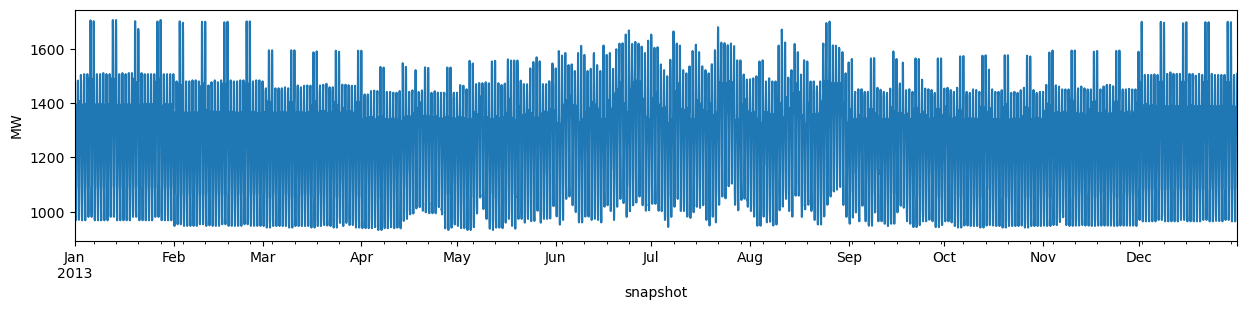

In [24]:
network.loads_t.p_set.sum(axis=1).plot(figsize=(15, 3), ylabel="MW")